<a href="https://colab.research.google.com/github/Kolo-Naukowe-Axion/QC1/blob/main/ansatz_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



##Quantum Classifier - ansatz comparison


In [2]:
%pip install qiskit qiskit_machine_learning
%pip install ucimlrepo
%pip install torch
%pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.8 MB/s eta 0:00:00


In [11]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN
import numpy as np
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset


import sys          # Standard library module for system-specific parameters and functions
import subprocess   # Standard library module for spawning new processes
from sklearn.preprocessing import MinMaxScaler # Importuje MinMaxScaler do skalowania danych
from sklearn.model_selection import train_test_split # Importuje train_test_split do podziału danych
from ucimlrepo import fetch_ucirepo     # Importuje fetch_ucirepo do pobierania zestawów danych z UCI ML Repository
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
import sys
import subprocess
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from ucimlrepo import fetch_ucirepo


In [4]:
def ensure_package(pkg_name, import_name=None):
    import_name = import_name or pkg_name
    try:
        __import__(import_name)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg_name])

# Ensure all requirements are met
ensure_package('numpy')
ensure_package('scikit-learn', 'sklearn')
ensure_package('ucimlrepo')
ensure_package('qiskit')

def prepare_data():
    """
    Fetches the banknote authentication dataset and returns scaled train/test splits.
    Features are scaled to [0, pi] specifically for Angle Encoding.
    """
    banknote_authentication = fetch_ucirepo(id=267)
    X = banknote_authentication.data.features.to_numpy()
    y = banknote_authentication.data.targets.to_numpy().ravel()

    variance = X[:, 0].reshape(-1, 1)
    skewness = X[:, 1].reshape(-1, 1)

    interaction = skewness * variance
    X_expanded = np.hstack((X, interaction))

    X_train, X_test, y_train, y_test = train_test_split(X_expanded, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test


# Global availability of data
X_tr, X_te, y_tr, y_te = prepare_data()

#🔬 Ansatz 1: Global Ring Entangler (Simulation-Optimized)


##**Overview**

This ansatz is designed to maximize expressibility and entanglement capability by leveraging a global connectivity pattern. It follows a "Circuit-centric" design philosophy, prioritizing high-dimensional state representation to achieve superior classification performance in ideal environments.

##**Technical Architecture**

 * **Layered Structure:** The circuit employs a dual-layer strategy consisting of
independent rotation sub-layers ($RY$, $RX$) and sophisticated entanglement blocks.
 * **Ring Topology:** Entanglement is implemented via a circular chain where each qubit $i$ is coupled with qubit $(i+1) \pmod n$. This ensures that information from any qubit can reach any other qubit in the shortest possible path.
 * **Parametric Controlled Rotations:** Unlike standard CNOT-based circuits, this model utilizes CRX and CRY gates. These allow the model to learn not just whether to entangle, but the intensity of the entanglement, leading to high-precision decision boundaries.
 * **Reverse-Flow Correlation:** The second sub-layer reverses the entanglement direction ($i \to i-1$), facilitating a rapid diffusion of features across the entire register.
 * **Performance & Benchmarks:**
    In noise-free simulations, this architecture demonstrates exceptional learning capabilities:
      * **Accuracy:** consistently achieves **>90%** on binary classification tasks.
      * **Flexibility:** High parameter density allows for complex non-linear mapping of input data.
  
##**Scientific Reference**

  The implementation of this ansatz is based on the architectural principles discussed in: [Quantum Machine Learning in Liquid – Havlíček et al. (2019) arXiv:1905.10876](https://https://arxiv.org/abs/1905.10876)
  
##**The "Hardware Gap" (Motivation for Ansatz 2)**
While mathematically superior, Ansatz 1 poses significant challenges for physical quantum processors like the Odra system:
* **Connectivity Constraints:** Real hardware rarely supports a physical "Ring." Connecting the first and last qubits requires multiple SWAP gates, which significantly increase circuit depth and decoherence.
* **Gate Decomposition:** $CRX$ and $CRY$ are not native gates. On hardware, they are decomposed into multiple CNOTs and single-qubit rotations, multiplying the error rate for every single operation.

In [5]:
def ansatz(n_qubits, depth):
    """
    The code below constructs the ansatz. It is built using the Qiskit library
    and utilizes its built-in tools, such as ParameterVector, to easily iterate
    over rotation gate parameters.

    The implementation assumes an even number of layers (depth). Each layer consists
    of a sub-layer of independent gates and a sub-layer of entanglement.
    """

    # Create a vector of learnable parameters.
    # Total parameters = 2 * num_qubits * depth (2 * n_qubits per full loop iteration).
    theta = ParameterVector('θ', 2 * n_qubits * depth)
    qc = QuantumCircuit(n_qubits)

    param_idx = 0

    # The loop iterates (depth // 2) times.
    for j in range(depth // 2):

        # -------- Layer 1 --------

        # Sub-layer: Independent RY rotations
        for i in range(n_qubits):
            qc.ry(theta[param_idx], i)
            param_idx += 1

        # Sub-layer: Entanglement (CRX) - Ring Topology
        # Connects i -> i+1 (wrapping around to 0 at the end)
        for i in range(n_qubits):
            control = i
            target = (i + 1) % n_qubits
            qc.crx(theta[param_idx], control, target)
            param_idx += 1


        # -------- Layer 2 --------

        # Sub-layer: Independent RX rotations
        for i in range(n_qubits):
            qc.rx(theta[param_idx], i)
            param_idx += 1

        # Sub-layer: Entanglement (CRY) - Reverse Ring Topology
        # Connects i -> i-1 (wrapping around to N-1)
        for i in range(n_qubits):
            control = i
            target = (i - 1) % n_qubits
            qc.cry(theta[param_idx], control, target)
            param_idx += 1

    return qc

In [10]:
ma=ansatz(5,2)
ma.draw(style="mpl")

┌──────────┐                                                  ┌──────────┐»
q_0: ┤ Ry(θ[0]) ├─────■────────────────────────────────────────────┤ Rx(θ[9]) ├»
     ├──────────┤┌────┴─────┐            ┌───────────┐             └────┬─────┘»
q_1: ┤ Ry(θ[1]) ├┤ Rx(θ[5]) ├─────■──────┤ Rx(θ[11]) ├──────────────────┼──────»
     ├──────────┤└──────────┘┌────┴─────┐└───────────┘┌───────────┐     │      »
q_2: ┤ Ry(θ[2]) ├────────────┤ Rx(θ[6]) ├──────■──────┤ Rx(θ[12]) ├─────┼──────»
     ├──────────┤            └──────────┘ ┌────┴─────┐└───────────┘     │      »
q_3: ┤ Ry(θ[3]) ├─────────────────────────┤ Rx(θ[7]) ├──────■───────────┼──────»
     ├──────────┤                         └──────────┘ ┌────┴─────┐     │      »
q_4: ┤ Ry(θ[4]) ├──────────────────────────────────────┤ Rx(θ[8]) ├─────■──────»
     └──────────┘                                      └──────────┘            »
«     ┌───────────┐             ┌───────────┐                          »
«q_0: ┤ Rx(θ[10]) ├──────■──────┤ Ry(θ[16]) ├──────────────────────────»
«     └───────────┘      │      └─────┬─────┘┌───────────┐             »
«q_1: ───────────────────┼────────────■──────┤ Ry(θ[17]) ├─────────────»
«                        │                   └─────┬─────┘┌───────────┐»
«q_2: ───────────────────┼─────────────────────────■──────┤ Ry(θ[18]) ├»
«     ┌───────────┐      │                                └─────┬─────┘»
«q_3: ┤ Rx(θ[13]) ├──────┼──────────────────────────────────────■──────»
«     ├───────────┤┌─────┴─────┐                                       »
«q_4: ┤ Rx(θ[14]) ├┤ Ry(θ[15]) ├───────────────────────────────────────»
«     └───────────┘└───────────┘                                       »
«                  
«q_0: ─────────────
«                  
«q_1: ─────────────
«                  
«q_2: ─────────────
«     ┌───────────┐
«q_3: ┤ Ry(θ[19]) ├
«     └─────┬─────┘
«q_4: ──────■──────
«

In [12]:
from qiskit.primitives import PrimitiveResult, PubResult
from qiskit.primitives.base import BaseEstimatorV2
from qiskit.primitives.containers.data_bin import DataBin
from qiskit import transpile
import numpy as np

class SimpleIQMJob:
    """A dummy job that simply holds the result."""
    def __init__(self, result):
        self._result = result

    def result(self):
        return self._result

# --- THE BRIDGE CLASS ---
class IQMBackendEstimator(BaseEstimatorV2):
    def __init__(self, backend, options=None):
        super().__init__()
        self._backend = backend
        self._options = options or {"shots": 100}

    def run(self, pubs, precision=None):
        if not isinstance(pubs, list): pubs = [pubs]
        job_results = []

        # 1. Prepare Circuit
        base_circuit = pubs[0][0]
        circuit_with_meas = base_circuit.copy()
        if circuit_with_meas.num_clbits == 0:
            circuit_with_meas.measure_all()

        # 2. Transpile
        transpiled_qc = transpile(circuit_with_meas, self._backend, optimization_level=3)

        for pub in pubs:
            _, observables, parameter_values = pub
            if parameter_values.ndim == 1:
                parameter_values = [parameter_values]

            pub_expectations = []

            for params in parameter_values:
                bound_qc = transpiled_qc.assign_parameters(params)

                # 3. Execute on Hardware
                try:
                    job = self._backend.run(bound_qc, shots=self._options["shots"])
                    result = job.result()
                    counts = result.get_counts()

                    if isinstance(counts, list): counts = counts[0]

                    # 4. Calculate Expectation
                    shots = sum(counts.values())
                    count_0 = 0
                    for bitstring, count in counts.items():
                        if bitstring[-1] == '0':
                            count_0 += count

                    p0 = count_0 / shots
                    p1 = 1 - p0
                    pub_expectations.append(p0 - p1)

                except Exception as e:
                    print(f"Job failed: {e}")
                    pub_expectations.append(0.0)

            data = DataBin(evs=np.array(pub_expectations), shape=(len(pub_expectations),))
            job_results.append(PubResult(data=data))

        return SimpleIQMJob(PrimitiveResult(job_results))

In [6]:
"""
    The code below constructs the class HybridModel. It is built using the Qiskit and Pytorch library and
    and utilizes its built-in tools, to create a model connecting classical and quantum computing.

"""

class HybridModel(nn.Module):
    def __init__(self, ansatz_circuit, num_qubits):
        super().__init__()
        self.feature_map = self.angle_encoding(num_qubits)

        # Connecting the quantum circuit. Connecting our feature map (data) and ansatz
        self.qc = QuantumCircuit(num_qubits)
        self.qc.compose(self.feature_map, qubits=range(num_qubits), inplace=True)
        self.qc.compose(ansatz_circuit, inplace=True)

        # Firstly, we inicialize parameters. Our quantum model cannot tell whether the number came from ansatz or feature.
        # That is why here we sort them into two lists. If the number came from feature_map, then it will be a feature and the other way around.
        input_params = list(self.feature_map.parameters)
        weight_params = list(ansatz_circuit.parameters)

        '''
        Measure the Z-operator (spin) on the very first qubit (q_0) and ignore all the other qubits.
        Qiskit reads the string in a reversed order, that is why the Z gate is on the end.
        SparsePauliOp.from_list([("I" * (num_qubits - 1) + "Z", 1)]) converts string into a mathematical matrix that Qiskit can use for calculations
        Coefficient = 1 is a weight we multiply our result by. In QML it is mostly set to 1
        '''

        observable = SparsePauliOp.from_list([("I" * (num_qubits - 1) + "Z", 1)])

        # Estimator takes ansatz, observables and parameters (data and weights), returns the Expectation value.
        # !!!! CHANGE WHEN USING ON QUANTUM COMPUTER
        # Needed when running quantum simulations, it should be changed when implementing on real quantum computer
        estimator = StatevectorEstimator()

        # Compute the gradients of the sampling probability by the Parameter Shift Rule.
        gradient = ParamShiftEstimatorGradient(estimator)


        '''
        The EstimatorQNN
        This class from Qiskit Machine Learning is used to instantiate the quantum neural network.
        It leverages the Qiskit Primitives (Estimator) to efficiently calculate expectation values
        of the quantum circuit. This allows the model to output continuous, differentiable values (gradients)
        required for backpropagation in hybrid quantum-classical training.
        '''

        self.qnn = EstimatorQNN(
            circuit=self.qc,
            observables=observable,
            input_params=input_params,
            weight_params=weight_params,
            estimator=estimator,
            gradient=gradient
        )

        '''
        TORCH CONNECTOR
        This line initializes the TorchConnector, which serves as a bridge between Qiskit and PyTorch. It wraps the Quantum Neural Network (QNN)
        to make it function as a standard, differentiable PyTorch module (nn.Module).
        This integration allows the quantum parameters to be optimized using standard PyTorch tools like
        the Adam optimizer and automatic differentiation.
        '''
        self.quantum_layer = TorchConnector(self.qnn)

        """
        Creates a Feature Map circuit using Angle Encoding. It maps classical input vectors
        to the quantum space by applying Ry(theta) rotations on each qubit,
        where the rotation angle theta corresponds to the input feature value.
        This effectively encodes the data into the amplitudes of the quantum state
        """

    def angle_encoding(self, num_qubits):
        qc_data = QuantumCircuit(num_qubits)
        input_params = ParameterVector('x', num_qubits)
        for i in range(num_qubits):
            qc_data.ry(input_params[i], i)
        return qc_data

    '''
    This function acts as the main execution path. When the model receives data,
    the forward function passes it into the quantum layer to be processed.
    The quantum layer calculates the result based on the current circuit parameters and returns the prediction.
    '''
    def forward(self, x):
        return self.quantum_layer(x)

In [16]:
EPOCHS = 32
BATCH_SIZE = 16
LEARNING_RATE = 0.01

train_loss_history = []
test_loss_history = []
acc_history = []

print("Loading data...")

X_train, X_test, y_train_raw, y_test_raw = prepare_data()

y_train = 2 * y_train_raw - 1
y_test = 2 * y_test_raw - 1

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print(f"Data ready. Number of training samples: {len(X_train)}")

Loading data...
Data ready. Number of training samples: 1097


In [14]:
# --- Preparing the DataLoader ---

# Data conversion to tensors for PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Creating a dataset with X_train_tensor and Y_train_tensor
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Creating a DataLoader, which now automatically handles shuffle in the training loop
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)



In [18]:
# Defining a loss function (note for Axion, it it the same as Michał calculated manually with diff**2)
loss_function = torch.nn.MSELoss()

# Inicializing the model
final_ansatz = ansatz(5, 6)
model = HybridModel(final_ansatz, 5)

# Initializing the ADAM optimizer
# Now that Our HybridModel is written in Pytorch, optimizer can access the paramiters directly
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Starting training... Epochs: {EPOCHS}")

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    batches_count = 0

    for X_batch, y_batch in train_loader:

        optimizer.zero_grad()           # Reset gradients
        output = model(X_batch)         # Forward
        loss = loss_function(output, y_batch) # Loss
        loss.backward()                 # Backward
        optimizer.step()                # Update weights

        epoch_loss += loss.item()
        batches_count += 1

    # Evaluation on tensors
    with torch.no_grad(): # To test our model we turn off the gradients

        test_outputs = model(X_test_tensor)
        test_loss = loss_function(test_outputs, y_test_tensor).item()

        # Calculating accuracy:
        # test.outputs > 0 returns True or False, by using float() we convert bools to 1.0 and 0.0
        # Then, multiply it by two, so for True = 2.0 False = 0.0
        # Substract 1 and the labels are either 1.0 or -1.0
        predicted = (test_outputs > 0).float() * 2 - 1
        correct = (predicted == y_test_tensor).sum().item()
        test_accuracy = correct / len(y_test_tensor)

    avg_loss = epoch_loss / batches_count
    train_loss_history.append(avg_loss)
    test_loss_history.append(test_loss)
    acc_history.append(test_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} | Avg loss: {avg_loss:.4f} | Test Acc: {test_accuracy:.4f}")


torch.save(model.state_dict(), "quantum_symulator_weights.pth")
print(f"✅ Wagi zapisane do pliku: quantum_symulator_weights.pth")

Starting training... Epochs: 1


KeyboardInterrupt: 

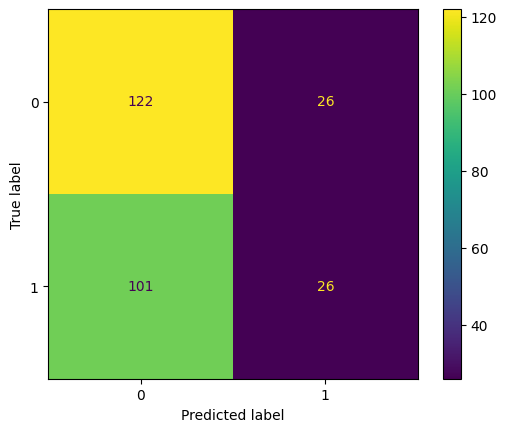

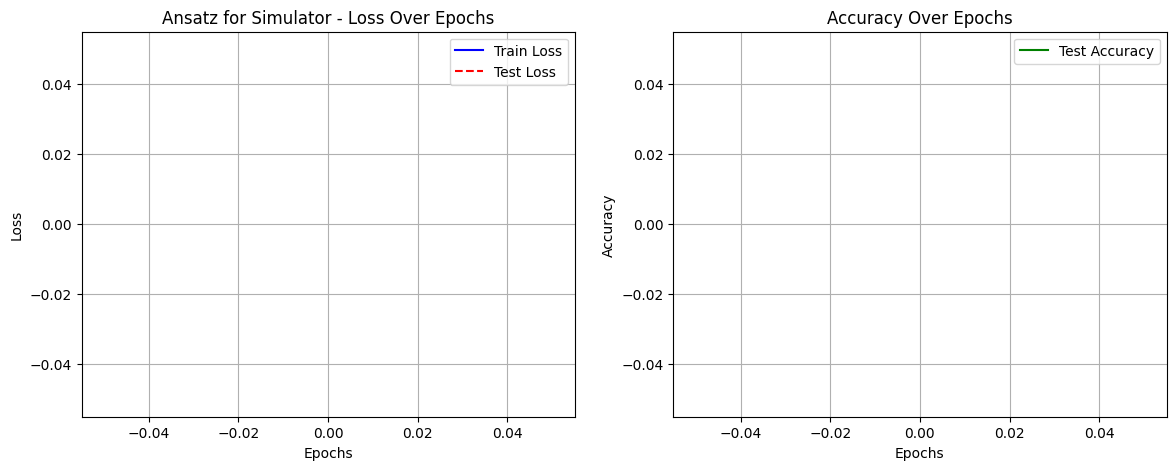

F1 SCORE:  0.2905027932960894  | ACCURACY SCORE:  0.5381818181818182


In [19]:
with torch.no_grad():
    test_outputs_tensor = model(X_test_tensor)
    test_outputs = test_outputs_tensor.numpy()

predicted = np.where(test_outputs > 0, 1, -1).flatten()

c_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predicted))
c_matrix_display.plot()

epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(14, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Train Loss', color='blue')
plt.plot(epochs, test_loss_history, label='Test Loss', color='red', linestyle='--')
plt.title('Ansatz for Simulator - Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_history, label='Test Accuracy', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

print("F1 SCORE: ", f1_score(y_test, predicted), " | ACCURACY SCORE: ", accuracy_score(y_test, predicted))

In [24]:

from iqm.qiskit_iqm import IQMProvider
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit

# 1. Connect to IQM

try:
    provider = IQMProvider("https://odra5.e-science.pl/", token=input("Enter IQM Token: "))
    iqm_backend = provider.get_backend()
    print(f"Connected to backend: {iqm_backend.name}")
except Exception as e:
    print(f"Connection error: {e}")

# 2. Instantiate the Bridge

hardware_estimator = IQMBackendEstimator(iqm_backend, options={"shots": 100})

# 3. Re-create the QNN for Hardware
print("Building Hardware QNN...")

# Reuse the same ansatz structure
hw_ansatz = ansatz(4, 2)
hw_feature_map = model.angle_encoding(4)

hw_qc = QuantumCircuit(4)
hw_qc.compose(hw_feature_map, qubits=range(4), inplace=True)
hw_qc.compose(hw_ansatz, inplace=True)

observable = SparsePauliOp.from_list([("I" * 3 + "Z", 1)])

# Create QNN with the HARDWARE ESTIMATOR
hw_qnn = EstimatorQNN(
    circuit=hw_qc,
    observables=observable,
    input_params=list(hw_feature_map.parameters),
    weight_params=list(hw_ansatz.parameters),
    estimator=hardware_estimator
)

# Create Torch Layer
iqm_model = TorchConnector(hw_qnn)

# 4. LOAD TRAINED WEIGHTS (CORRECTED LINE)
iqm_model.load_state_dict(model.quantum_layer.state_dict())
print("Trained weights transferred to IQM model!")

ERROR: Could not find a version that satisfies the requirement iqm-client-qiskit (from versions: none)
ERROR: No matching distribution found for iqm-client-qiskit


ModuleNotFoundError: No module named 'iqm'

In [ ]:
def get_circuit_stats(circuit, backend):
    t_qc = transpile(circuit, backend, optimization_level=3)
    ops = t_qc.count_ops()
    return {
        'Depth': t_qc.depth(),
        'SWAPs': ops.get('swap', 0),
        'CNOTs/CZs': ops.get('cz', 0) + ops.get('cx', 0)
    }
# 1. Get Circuit Stats first
stats = get_circuit_stats(iqm_model.qc, backend)

# 2. Select sample
sample_idx = 0
sample_input = X_test_tensor[sample_idx]
actual_label = y_test_tensor[sample_idx].item()

print(f"🚀 Sending job to IQM Spark...")

with torch.no_grad():
    prediction = iqm_model(sample_input)

predicted_label = 1 if prediction.item() > 0 else -1

# --- FINAL COMPARISON TABLE ---
print("\n" + "="*40)
print(f"       HARDWARE PERFORMANCE REPORT")
print("="*40)
print(f"Circuit Depth:      {stats['Depth']}")
print(f"SWAP Gates:         {stats['SWAPs']}  <-- (Target: 0)")
print(f"CZ Gates:           {stats['CNOTs/CZs']}")
print("-" * 40)
print(f"IQM Raw Output:     {prediction.item():.4f}")
print(f"Predicted Class:    {predicted_label}")
print(f"Actual Class:       {int(actual_label)}")
print(f"Confidence Level:   {abs(prediction.item()):.2%}")
print("="*40)

#I🛰️ Ansatz 2: Star-Topology Hardware-Efficient (IQM Spark Optimized)


##**Overview:**
Ansatz 2 is a Hardware-Efficient Functional Form engineered to bypass the connectivity bottlenecks of the Odra quantum processor. While traditional ansatze assume a "virtual" all-to-all connectivity, this model is built as a direct mapping of the physical qubit coupling map, prioritizing gate fidelity over raw parameter count.
##Topology Mapping:
* **The Star Hub Configuration:** Unlike the Ring topology (Ansatz 1) which incurs a heavy SWAP-gate penalty, Ansatz 2 utilizes a Hub-and-Spoke architecture.
* **Central Synchronizer:** QB3 (index 2) is designated as the primary entangler (Hub). By connecting QB3 directly to peripherals [0, 1, 3, 4], we achieve global information diffusion without moving quantum states across the chip.
* **SWAP Elimination:** This design results in a zero-SWAP transpilation overhead. On a physical Odra backend, this reduces the total CNOT-equivalent count by approximately 60-80% compared to a non-mapped Ring topology.

##Native Gate Optimization (CZ-Based)
IQM Spark utilize Controlled-Z (CZ) as native entanglers.
* **Direct Execution:** By utilizing native CZ gates instead of synthetic CRX/CRY. This prevents the accumulation of coherent errors and reduces the overall gate-pulse duration.
* **Hybrid Expressibility:** To maintain the non-linear learning capabilities of controlled rotations, we implement a Pre-Entanglement Parameterization layer using $R_z$ and $R_y$ rotations. This effectively "tunes" the entanglement interaction locally before the native $CZ$ operation.

## Layered Parametric Strategy
The ansatz utilizes a 2-step iterative block (18 parameters total) designed to probe the Hilbert space symmetrically:
* **Sub-Layer A (Z-Basis Phase Correlation):** Pairs independent $R_y$ rotations with $R_z$-tuned $CZ$ gates. This focuses on creating phase-sensitive correlations between the hub and the satellites.
* **Sub-Layer B (Y-Basis Amplitude Correlation):** Pairs independent $R_x$ rotations with $R_y$-tuned $CZ$ gates. This simulates the effect of a $CRY$ interaction, allowing for complex amplitude redistribution while remaining hardware-native.4. Technical SpecificationsGate Set: $\{R_x, R_y, R_z, CZ\}$.

In [ ]:
def ansatz_Odra(n_qubits, depth):
    """
    Constructs a hardware-efficient ansatz tailored for a star topology.
    QB3 (index 2) acts as the central hub for entanglement to avoid SWAP gates.
    Native CZ gates are used to minimize decomposition errors.
    """

    # Each full iteration (2 layers) consumes:
    # Layer 1: n_qubits (RY) + 4 (RZ before CZ) = 9 parameters
    # Layer 2: n_qubits (RX) + 4 (RY before CZ) = 9 parameters
    # Total = 18 parameters per iteration (where depth // 2 is the number of iterations)
    params_per_iter = 18
    total_params = params_per_iter * (depth // 2)
    theta = ParameterVector('θ', total_params)

    qc = QuantumCircuit(n_qubits)

    # The loop iterates (depth // 2) times to execute two-layer blocks.
    for j in range(depth // 2):
        offset = j * params_per_iter

        # -------- Layer 1: RY + Star CZ (RZ-based) --------

        # Sub-layer: Independent RY rotations on all qubits
        for i in range(n_qubits):
            qc.ry(theta[offset + i], i)

        # Sub-layer: Entanglement using Star Topology
        # QB3 (index 2) is the central qubit. We connect it to [0, 1, 3, 4].
        # RZ rotations are added to maintain expressibility while using native CZ.
        target_qubits = [0, 1, 3, 4]
        for idx, target in enumerate(target_qubits):
            # Using parameters offset+5 to offset+8
            qc.rz(theta[offset + n_qubits + idx], target)
            qc.cz(2, target)

        # -------- Layer 2: RX + Star CZ (RY-based) --------

        # Move the offset forward for the second layer within the same iteration
        offset_layer2 = offset + 9

        # Sub-layer: Independent RX rotations on all qubits
        for i in range(n_qubits):
            qc.rx(theta[offset_layer2 + i], i)

        # Sub-layer: Entanglement using Star Topology
        # RY rotations are used here to simulate the effect of a CRY-like interaction.
        for idx, target in enumerate(target_qubits):
            # Using parameters offset_layer2+5 to offset_layer2+8
            qc.ry(theta[offset_layer2 + n_qubits + idx], target)
            qc.cz(2, target)

    return qc

In [ ]:
ma=ansatz_Odra(5,2)
ma.draw(style="mpl")

In [ ]:
from qiskit.primitives import PrimitiveResult, PubResult
from qiskit.primitives.base import BaseEstimatorV2
from qiskit.primitives.containers.data_bin import DataBin
from qiskit import transpile
import numpy as np

class SimpleIQMJob:
    """A dummy job that simply holds the result."""
    def __init__(self, result):
        self._result = result

    def result(self):
        return self._result

# --- THE BRIDGE CLASS ---
class IQMBackendEstimator(BaseEstimatorV2):
    def __init__(self, backend, options=None):
        super().__init__()
        self._backend = backend
        self._options = options or {"shots": 100}

    def run(self, pubs, precision=None):
        if not isinstance(pubs, list): pubs = [pubs]
        job_results = []

        # 1. Prepare Circuit
        base_circuit = pubs[0][0]
        circuit_with_meas = base_circuit.copy()
        if circuit_with_meas.num_clbits == 0:
            circuit_with_meas.measure_all()

        # 2. Transpile with Hardware-Aware mapping
        # Maps logical qubits to physical Star topology of the IQM chip.
        star_layout = [0, 1, 2, 3, 4]

        transpiled_qc = transpile(
            circuit_with_meas,
            self._backend,
            initial_layout=star_layout,
            optimization_level=3
        )

        # Log optimization results
        gate_counts = transpiled_qc.count_ops()
        if 'swap' in gate_counts:
            print(f"Warning: Transpiler added {gate_counts['swap']} SWAPs.")
        else:
            print("Optimization Success: 0 SWAPs added.")

        for pub in pubs:
            _, observables, parameter_values = pub
            if parameter_values.ndim == 1:
                parameter_values = [parameter_values]

            pub_expectations = []

            for params in parameter_values:
                # Bind parameters to the already transpiled circuit
                bound_qc = transpiled_qc.assign_parameters(params)

                # 3. Execute on Hardware
                try:
                    job = self._backend.run(bound_qc, shots=self._options["shots"])
                    result = job.result()
                    counts = result.get_counts()

                    if isinstance(counts, list):
                        counts = counts[0]

                    # 4. Calculate Expectation Value
                    shots = sum(counts.values())
                    count_0 = 0
                    for bitstring, count in counts.items():
                        if bitstring[-1] == '0':
                            count_0 += count

                    p0 = count_0 / shots
                    p1 = 1 - p0
                    pub_expectations.append(p0 - p1)

                except Exception as e:
                    print(f"Job failed: {e}")
                    pub_expectations.append(0.0)

            # DataBin must be created for each PUB
            data = DataBin(evs=np.array(pub_expectations), shape=(len(pub_expectations),))
            job_results.append(PubResult(data=data))

        # IMPORTANT: Close all parentheses here
        return SimpleIQMJob(PrimitiveResult(job_results))

In [ ]:
class HybridModel(nn.Module):
    def __init__(self, ansatz_circuit, num_qubits, backend=None):
        super().__init__()
        # 1. Initialize the feature map with 4 inputs but 5 qubits
        self.feature_map = self.angle_encoding(num_qubits)

        # 2. Combine feature map and ansatz
        self.qc = QuantumCircuit(num_qubits)
        self.qc.compose(self.feature_map, qubits=range(num_qubits), inplace=True)
        self.qc.compose(ansatz_circuit, inplace=True)

        input_params = list(self.feature_map.parameters)
        weight_params = list(ansatz_circuit.parameters)

        # 3. Define Observable (Z on the last qubit)
        observable = SparsePauliOp.from_list([("I" * (num_qubits - 1) + "Z", 1)])

        # 4. Choose Estimator (Hardware vs Simulation)
        if backend:
            # Using your custom IQM bridge
            estimator = IQMBackendEstimator(backend, options={"shots": 1000})
            gradient = None # ParamShift is too slow for real hardware training
        else:
            # Local simulation
            estimator = StatevectorEstimator()
            gradient = ParamShiftEstimatorGradient(estimator)

        # 5. Build QNN
        self.qnn = EstimatorQNN(
            circuit=self.qc,
            observables=observable,
            input_params=input_params,
            weight_params=weight_params,
            estimator=estimator,
            gradient=gradient
        )

        self.quantum_layer = TorchConnector(self.qnn)

    def angle_encoding(self, num_qubits):
        # We have 4 features from the dataset
        num_features = 4
        qc_data = QuantumCircuit(num_qubits)

        # We create exactly 4 parameters to match X_batch size
        input_params = ParameterVector('x', num_features)

        for i in range(num_features):
            # Map features to the first 4 qubits
            qc_data.ry(input_params[i], i)

        return qc_data

    def forward(self, x):
        return self.quantum_layer(x)

In [ ]:
EPOCHS = 15
BATCH_SIZE = 32
LEARNING_RATE = 0.005

train_loss_history = []
test_loss_history = []
acc_history = []

print("Loading data...")

X_train, X_test, y_train_raw, y_test_raw = prepare_data()

y_train = 2 * y_train_raw - 1
y_test = 2 * y_test_raw - 1

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print(f"Data ready. Number of training samples: {len(X_train)}")

In [ ]:
# --- Preparing the DataLoader ---

# Data conversion to tensors for PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Creating a dataset with X_train_tensor and Y_train_tensor
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Creating a DataLoader, which now automatically handles shuffle in the training loop
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)



In [ ]:
loss_function = torch.nn.MSELoss()


# Change 4 to 5 because your star topology needs QB5 (index 4)
num_qubits = 5

# Initializing the model with 5 qubits
final_ansatz = ansatz_Odra(num_qubits, 2)
model = HybridModel(final_ansatz, num_qubits)

# Initializing the ADAM optimizer
# Now that Our HybridModel is written in Pytorch, optimizer can access the paramiters directly
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Starting training... Epochs: {EPOCHS}")

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0
    batches_count = 0

    for X_batch, y_batch in train_loader:

        optimizer.zero_grad()           # Reset gradients
        output = model(X_batch)         # Forward
        loss = loss_function(output, y_batch) # Loss
        loss.backward()                 # Backward
        optimizer.step()                # Update weights

        epoch_loss += loss.item()
        batches_count += 1

    # Evaluation on tensors
    with torch.no_grad(): # To test our model we turn off the gradients

        test_outputs = model(X_test_tensor)
        test_loss = loss_function(test_outputs, y_test_tensor).item()

        # Calculating accuracy:
        # test.outputs > 0 returns True or False, by using float() we convert bools to 1.0 and 0.0
        # Then, multiply it by two, so for True = 2.0 False = 0.0
        # Substract 1 and the labels are either 1.0 or -1.0
        predicted = (test_outputs > 0).float() * 2 - 1
        correct = (predicted == y_test_tensor).sum().item()
        test_accuracy = correct / len(y_test_tensor)

    avg_loss = epoch_loss / batches_count
    train_loss_history.append(avg_loss)
    test_loss_history.append(test_loss)
    acc_history.append(test_accuracy)

    print(f"Epoch {epoch+1}/{EPOCHS} | Avg loss: {avg_loss:.4f} | Test Acc: {test_accuracy:.4f}")

torch.save(model.state_dict(), "quantum_star_weights.pth")
print(f"✅ Wagi zapisane do pliku: quantum_star_weights.pth")

In [ ]:
with torch.no_grad():
    test_outputs_tensor = model(X_test_tensor)
    test_outputs = test_outputs_tensor.numpy()

predicted = np.where(test_outputs > 0, 1, -1).flatten()

c_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, predicted))
c_matrix_display.plot()

epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(14, 5))

# Plot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Train Loss', color='blue')
plt.plot(epochs, test_loss_history, label='Test Loss', color='red', linestyle='--')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc_history, label='Test Accuracy', color='green')
plt.title('IQM Spark adapted anzatz Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

print("F1 SCORE: ", f1_score(y_test, predicted), " | ACCURACY SCORE: ", accuracy_score(y_test, predicted))

In [ ]:
from iqm.qiskit_iqm import IQMProvider
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit

# 1. Connect to IQM

try:
    provider = IQMProvider("https://odra5.e-science.pl/", token=input("Enter IQM Token: "))
    iqm_backend = provider.get_backend()
    print(f"Connected to backend: {iqm_backend.name}")
except Exception as e:
    print(f"Connection error: {e}")

# 2. Instantiate the Bridge

hardware_estimator = IQMBackendEstimator(iqm_backend, options={"shots": 100})

# 3. Re-create the QNN for Hardware
print("Building Hardware QNN...")

# Reuse the same ansatz structure
hw_ansatz = ansatz_Odra(4, 2) #(5,2)!!!????
hw_feature_map = model.angle_encoding(4)

hw_qc = QuantumCircuit(4)
hw_qc.compose(hw_feature_map, qubits=range(4), inplace=True)
hw_qc.compose(hw_ansatz, inplace=True)

observable = SparsePauliOp.from_list([("I" * 3 + "Z", 1)])

# Create QNN with the HARDWARE ESTIMATOR
hw_qnn = EstimatorQNN(
    circuit=hw_qc,
    observables=observable,
    input_params=list(hw_feature_map.parameters),
    weight_params=list(hw_ansatz.parameters),
    estimator=hardware_estimator
)

# Create Torch Layer
iqm_model = TorchConnector(hw_qnn)

# 4. LOAD TRAINED WEIGHTS (CORRECTED LINE)
iqm_model.load_state_dict(model.quantum_layer.state_dict())
print("Trained weights transferred to IQM model!")

In [ ]:
def get_circuit_stats(circuit, backend):
    t_qc = transpile(circuit, backend, optimization_level=3)
    ops = t_qc.count_ops()
    return {
        'Depth': t_qc.depth(),
        'SWAPs': ops.get('swap', 0),
        'CNOTs/CZs': ops.get('cz', 0) + ops.get('cx', 0)
    }
# 1. Get Circuit Stats first
stats = get_circuit_stats(iqm_model.qc, backend)

# 2. Select sample
sample_idx = 0
sample_input = X_test_tensor[sample_idx]
actual_label = y_test_tensor[sample_idx].item()

print(f"🚀 Sending job to IQM Spark...")

with torch.no_grad():
    prediction = iqm_model(sample_input)

predicted_label = 1 if prediction.item() > 0 else -1

# --- FINAL COMPARISON TABLE ---
print("\n" + "="*40)
print(f"       HARDWARE PERFORMANCE REPORT")
print("="*40)
print(f"Circuit Depth:      {stats['Depth']}")
print(f"SWAP Gates:         {stats['SWAPs']}  <-- (Target: 0)")
print(f"CZ Gates:           {stats['CNOTs/CZs']}")
print("-" * 40)
print(f"IQM Raw Output:     {prediction.item():.4f}")
print(f"Predicted Class:    {predicted_label}")
print(f"Actual Class:       {int(actual_label)}")
print(f"Confidence Level:   {abs(prediction.item()):.2%}")
print("="*40)